# Podrobna analiza stories dataseta

In [1]:
import duckdb

import mplsoccer
from mplsoccer import Pitch, VerticalPitch

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df_players = duckdb.sql(f"""SELECT * FROM 'data/players.parquet' """).df()

In [3]:
df_teams = duckdb.sql(f"""SELECT * FROM 'data/teams.parquet' """).df()

In [4]:
df_stories = duckdb.sql(f"""SELECT * FROM 'data/stories.parquet' """).df()
df_stories

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,...,shot_goal_zone,conceded_goal,is_pass,possession_attack,pass_blocked,opportunity,possession_id,shot_id,possession_set_piece_attack,__index_level_0__
0,AMF,False,49,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,0
1,CF,False,27,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,1
2,LCMF,False,36,False,False,False,False,False,interception,False,...,None,False,True,True,False,False,1296149340,0,False,2
3,RCB,False,57,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,3
4,AMF,False,67,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946300,AMF,False,81,False,False,False,False,False,shot,False,...,otr,False,False,True,False,False,1854589816,0,False,1946300
1946301,None,False,0,False,False,False,False,False,game_interruption,False,...,None,False,False,False,False,False,-1,0,False,1946301
1946302,GK,False,0,False,False,False,False,False,goal_kick,False,...,None,False,True,False,False,False,1854589775,0,True,1946302
1946303,LAMF,False,24,False,False,True,False,False,pass,False,...,None,False,True,False,False,False,1854589775,0,True,1946303


In [5]:
# Filter and print column names that contain "match"
match_columns = [col for col in df_stories.columns if "match" in col.lower()]
print(match_columns)

['match_state']


In [6]:
df_stories["match_state"].value_counts()

match_state
 0    904808
-1    353220
 1    320276
 2    120763
-2    119849
 3     44120
-3     39325
 4     16408
-4     13389
 5      5847
-5      4056
 6      1887
-6      1132
 7       484
-7       372
 8       130
-8        89
 9        79
-9        71
Name: count, dtype: int64

Kaj je match_state???

## Vizualizacije

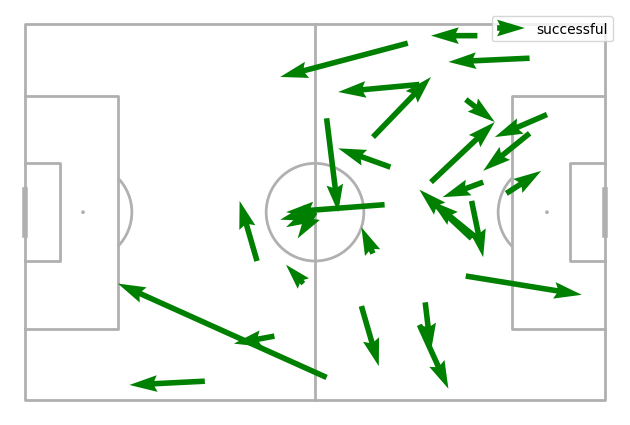

In [23]:
df_passes = duckdb.sql(f"""SELECT start_x, start_y, end_x, end_y, successful FROM 'data/stories.parquet'
                      WHERE is_pass
                      AND season = 2023
                      and player_id = 669602
                      USING SAMPLE 10%
                  """).df()

pitch = Pitch(pitch_type='wyscout')
fig, ax = pitch.draw()

pitch.arrows(df_passes[df_passes['successful']]['start_x'],
          df_passes[df_passes['successful']]['start_y'],
          df_passes[df_passes['successful']]['end_x'],
          df_passes[df_passes['successful']]['end_y'],

          ax=ax, color='green',
          label='successful'
          )

plt.legend()

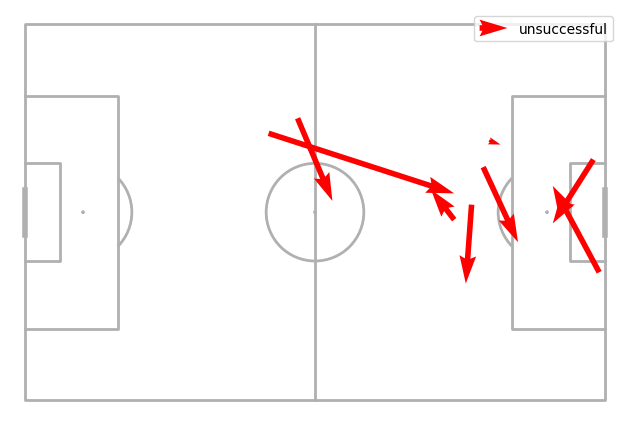

In [24]:
fig, ax = pitch.draw()

pitch.arrows(df_passes[~df_passes['successful']]['start_x'],
          df_passes[~df_passes['successful']]['start_y'],
          df_passes[~df_passes['successful']]['end_x'],
          df_passes[~df_passes['successful']]['end_y'],

          ax=ax, color='red',
          label='unsuccessful',
          )

plt.legend()

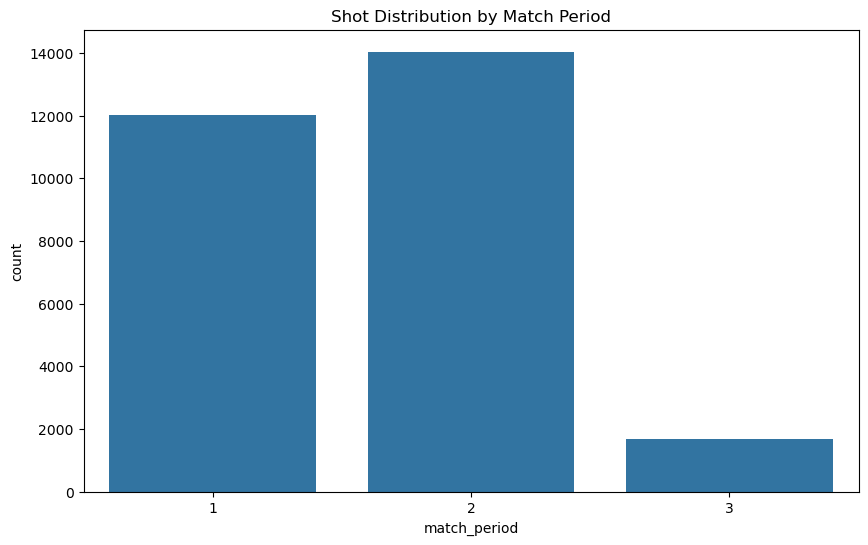

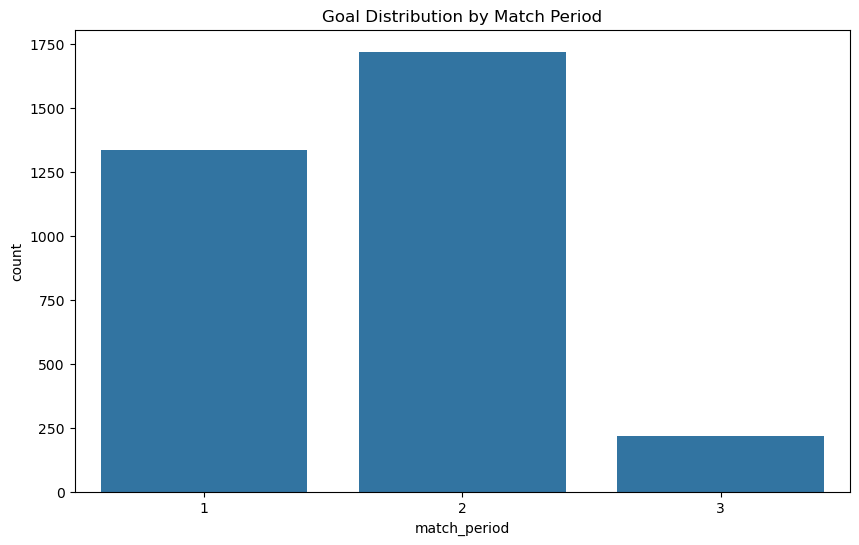

In [8]:
df_stories['match_period'] = df_stories['minute'] // 45 + 1  # Divide match into two halves

# Plot number of shots and goals per match period
event_types = ['shot', 'goal']
for event in event_types:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_stories[df_stories[event] == True], x='match_period')
    plt.title(f'{event.capitalize()} Distribution by Match Period')
    plt.show()

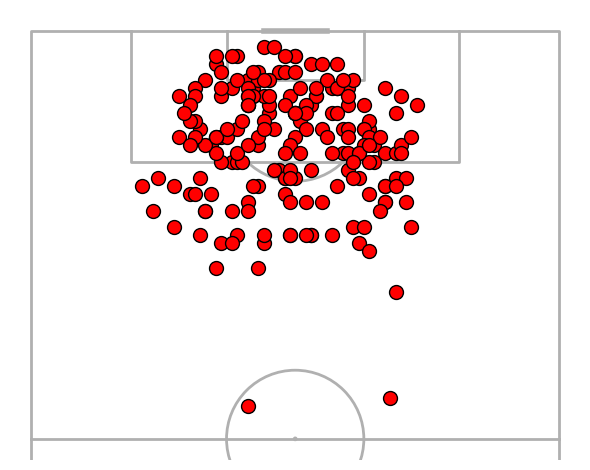

In [16]:
df_shots = duckdb.sql(f"""SELECT start_x, start_y, goal FROM 'data/stories.parquet'
                      WHERE shot_xg > 0
                      LIMIT 200
                  """).df()
pitch = VerticalPitch(pitch_type='wyscout', half=True)
fig, ax = pitch.draw()
pitch.scatter(df_shots['start_x'], df_shots['start_y'], ax=ax, s=100, color='red',
            edgecolors='black', zorder=1)

In [ ]:
# Calculate goal difference for each player
df_stories['goal_difference'] = df_stories.groupby('player_id')['goal'].transform('sum') - \
                                df_stories.groupby('player_id')['shot_xg'].transform('sum')

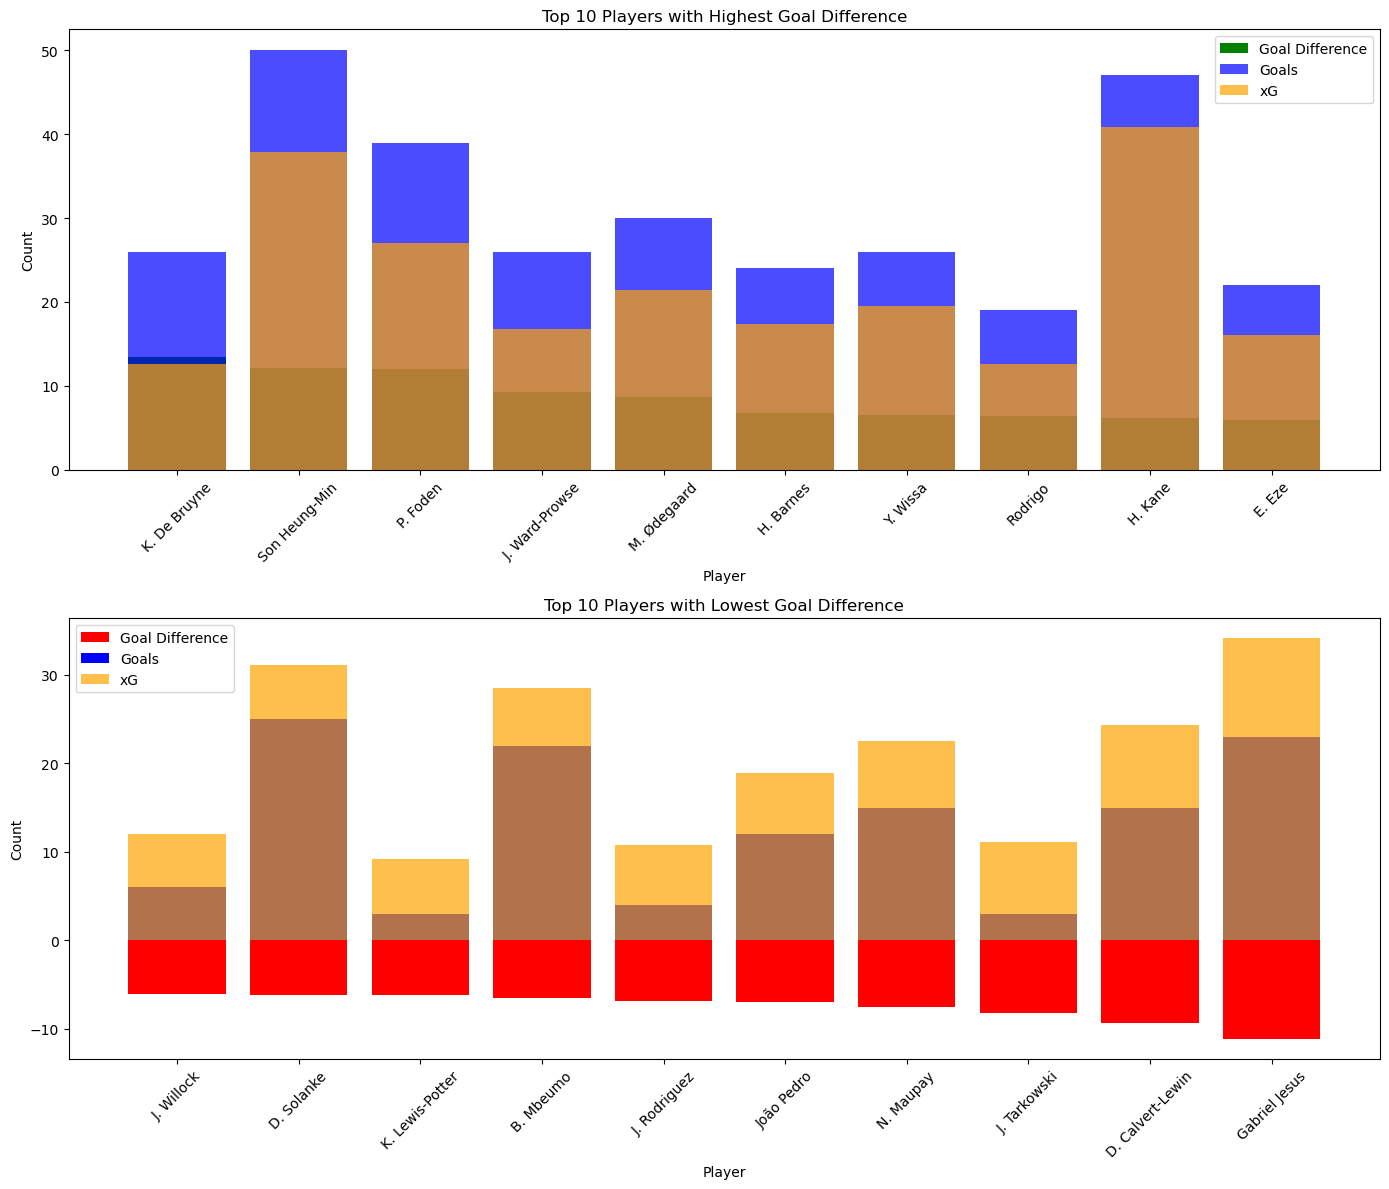

In [30]:
# Calculate goal difference for each player
df_stories['goal_difference'] = df_stories.groupby('player_id')['goal'].transform('sum') - \
                                df_stories.groupby('player_id')['shot_xg'].transform('sum')

# Calculate total goals and xG per player
goal_xg_summary = df_stories.groupby('player_id').agg(
    goal=('goal', 'sum'),
    shot_xg=('shot_xg', 'sum'),
    goal_difference=('goal_difference', 'mean')
).reset_index()

# Sort by goal_difference
goal_xg_summary = goal_xg_summary.sort_values(by='goal_difference', ascending=False)

# Ensure df_players contains player_id and short_name columns
# Merge the player short names into the goal_xg_summary dataframe
goal_xg_summary = goal_xg_summary.merge(
    df_players[['player_id', 'short_name']],
    on='player_id',
    how='left'
)

# Replace player_id with short_name for labeling
goal_xg_summary['player_label'] = goal_xg_summary['short_name']

# Top 10 players with highest goal difference
top_10_positive = goal_xg_summary.head(10)

# Top 10 players with lowest goal difference
top_10_negative = goal_xg_summary.tail(10)

# Plot for top 10 positive goal differences
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

axes[0].bar(top_10_positive['player_label'], top_10_positive['goal_difference'], color='green', label='Goal Difference')
axes[0].bar(top_10_positive['player_label'], top_10_positive['goal'], color='blue', label='Goals', alpha=0.7)
axes[0].bar(top_10_positive['player_label'], top_10_positive['shot_xg'], color='orange', label='xG', alpha=0.7)
axes[0].set_title("Top 10 Players with Highest Goal Difference")
axes[0].set_xlabel("Player")
axes[0].set_ylabel("Count")
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Plot for top 10 negative goal differences
axes[1].bar(top_10_negative['player_label'], top_10_negative['goal_difference'], color='red', label='Goal Difference')
axes[1].bar(top_10_negative['player_label'], top_10_negative['goal'], color='blue', label='Goals')
axes[1].bar(top_10_negative['player_label'], top_10_negative['shot_xg'], color='orange', label='xG', alpha=0.7)
axes[1].set_title("Top 10 Players with Lowest Goal Difference")
axes[1].set_xlabel("Player")
axes[1].set_ylabel("Count")
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Understanding possession correlation

Čas je določen z dvema značilkama in sicer minute ter second

In [31]:
id_columns = [col for col in df_stories.columns if "goal" in col.lower()]
print(id_columns)

['penalty_conceded_goal', 'own_goal', 'penalty_goal', 'goal_kick', 'own_goal_for', 'goalkeeper_exit', 'goal', 'possession_goal', 'shot_goal_zone', 'conceded_goal', 'goal_difference']


In [32]:
df_goals = duckdb.sql(f"""SELECT DISTINCT possession_id
                        FROM df_stories
                        WHERE goal = TRUE
                  """).df()

df_goals

,possession_id
0,1196308146
1,1196272346
2,1194112048
3,1193943791
4,1193944070
...,...
3267,1922928471
3268,1922930088
3269,1929053492
3270,1929053814


KO IMAMO POSESTI, KJER JE PADEL GOL, LAHKO DOSTOPAMO TUDI DO DRUGIH EVENTOV IN VIDIMO KAJ SE JE DOGAJALO PRED ZADETKOM:

In [33]:
# Filter rows where possession_id matches the target value
specific_possession = df_stories[df_stories['possession_id'] == 1196308146]

# Identify boolean columns (event-related attributes)
bool_columns = specific_possession.select_dtypes(include='bool').columns

# Iterate through the rows and extract events marked as True
for index, row in specific_possession.iterrows():
    true_events = [col for col in bool_columns if row[col]]
    print(f"Row {index}: Events - {', '.join(true_events) if true_events else 'No events marked True'}")


Row 227440: Events - assist, shot_assist, corner, possession_goal, possession_corner, possession_attack, possession_set_piece_attack
Row 227441: Events - shot_after_corner, head_shot, shot_on_target, goal, possession_goal, touch_in_box, shot, possession_corner, clear_header, possession_attack, opportunity, possession_set_piece_attack


In [34]:
# Filter rows where possession_id matches the target value
specific_possession = df_stories[df_stories['possession_id'] == 1196272346]

# Identify boolean columns (event-related attributes)
bool_columns = specific_possession.select_dtypes(include='bool').columns

# Iterate through the rows and extract events marked as True
for index, row in specific_possession.iterrows():
    true_events = [col for col in bool_columns if row[col]]
    print(f"Row {index}: Events - {', '.join(true_events) if true_events else 'No events marked True'}")


Row 230133: Events - recovery, short_or_medium_pass, possession_goal, possession_attack
Row 230134: Events - short_or_medium_pass, forward_pass, possession_goal, possession_attack
Row 230135: Events - short_or_medium_pass, back_pass, possession_goal, possession_attack
Row 230136: Events - short_or_medium_pass, forward_pass, possession_goal, possession_attack
Row 230137: Events - lateral_pass, third_assist, progressive_pass, pass_to_penalty_area, possession_goal, cross, pass_high, deep_completed_cross, possession_attack
Row 230138: Events - interception, second_assist, possession_goal, touch_in_box, possession_attack
Row 230139: Events - lateral_pass, key_pass, assist, shot_assist, progressive_pass, pass_to_penalty_area, possession_goal, cross, pass_high, deep_completed_cross, possession_attack
Row 230140: Events - shot_on_target, goal, possession_goal, touch_in_box, shot, possession_attack, opportunity


In [35]:
# Create a copy of df_stories
filtered_stories_df = df_stories[df_stories['possession_id'].isin(df_goals['possession_id'])].copy()

# Display the filtered DataFrame
filtered_stories_df.head()

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,...,possession_attack,pass_blocked,opportunity,possession_id,shot_id,possession_set_piece_attack,__index_level_0__,match_period,pass_success_rate,goal_difference
425,LAMF,False,90,False,False,False,False,False,penalty,False,...,True,False,False,1296149825,0,True,425,1,inf,5.244581
426,GK,False,2,True,False,False,False,False,shot_against,False,...,True,False,False,1296149825,0,True,426,1,0.0,0.000000
466,RAMF,False,100,False,False,False,False,False,corner,False,...,True,False,False,1296149887,0,True,466,1,0.0,3.756687
467,LAMF,False,97,False,False,False,False,False,pass,False,...,True,False,False,1296149887,1296151266,True,467,1,1.0,5.244581
468,CF,False,97,False,False,False,False,False,shot,False,...,True,False,True,1296149887,0,True,468,1,inf,-3.009033


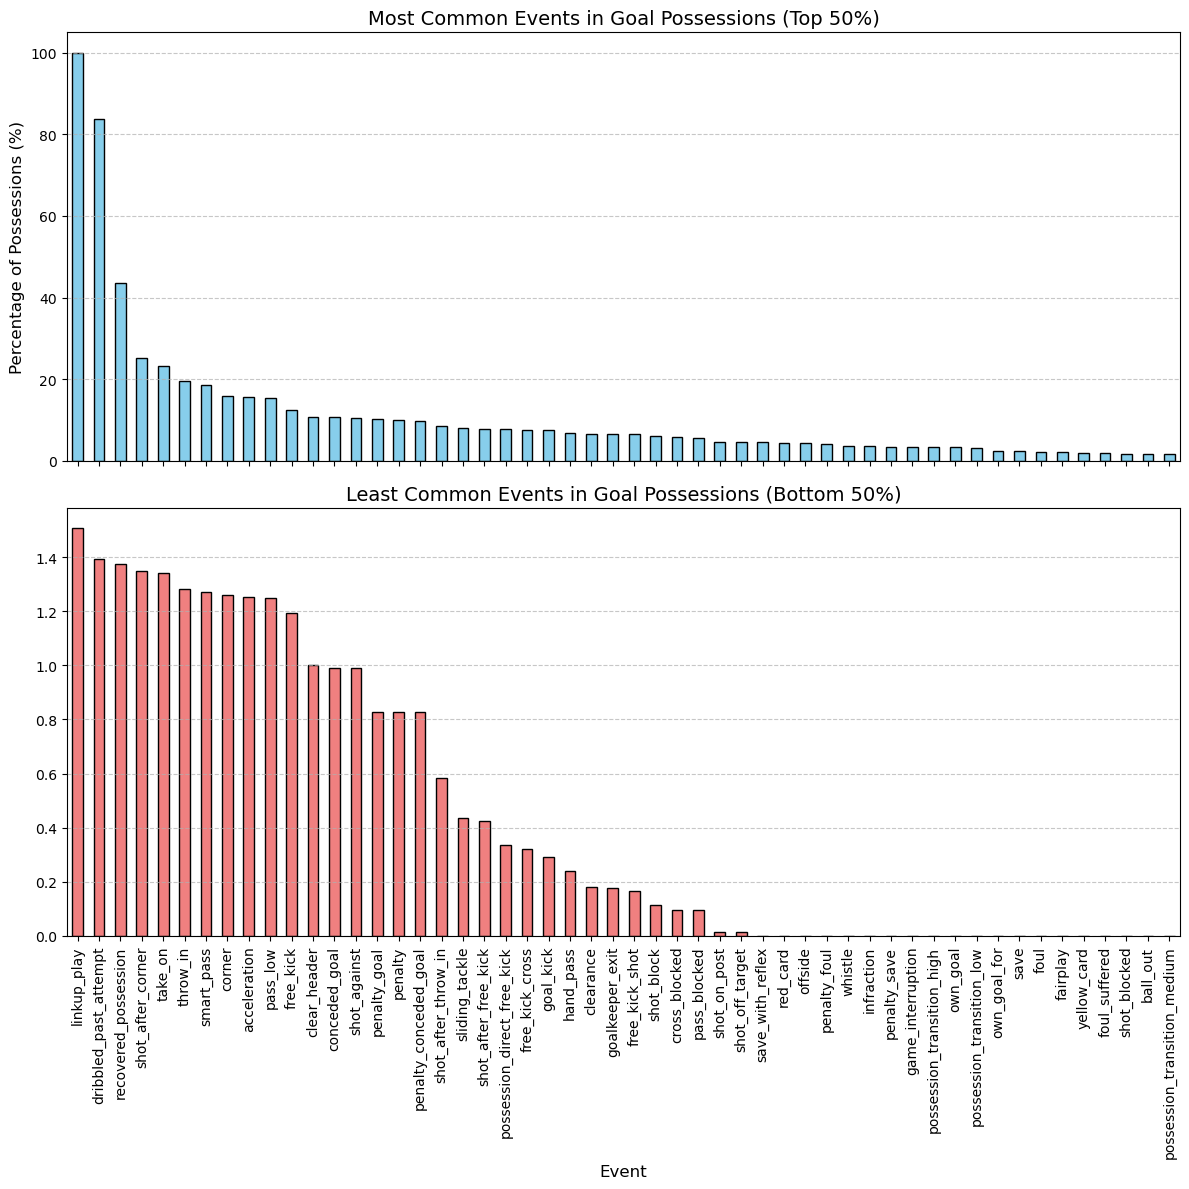

In [41]:
# Select only the event columns (exclude non-event columns and 'goal')
event_columns = [col for col in filtered_stories_df.columns if filtered_stories_df[col].dtype == 'bool' and col != 'goal']

# Count occurrences of each event in the filtered DataFrame
event_counts = filtered_stories_df[event_columns].sum()

# Calculate relative percentages
total_possessions = len(filtered_stories_df)
event_percentages = (event_counts / total_possessions * 100).sort_values(ascending=False)

# Split into two halves
mid_index = len(event_percentages) // 2
top_half = event_percentages[:mid_index]
bottom_half = event_percentages[mid_index:]

# Plot the graphs (stacked)
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Plot for the top half
top_half.plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('Most Common Events in Goal Possessions (Top 50%)', fontsize=14)
axes[0].set_ylabel('Percentage of Possessions (%)', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xticklabels(top_half.index, rotation=45)  # Set event names as x-tick labels
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for the bottom half
bottom_half.plot(kind='bar', color='lightcoral', edgecolor='black', ax=axes[1])
axes[1].set_title('Least Common Events in Goal Possessions (Bottom 50%)', fontsize=14)
axes[1].set_xlabel('Event', fontsize=12)
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticklabels(bottom_half.index, rotation=90)  # Set event names as x-tick labels
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

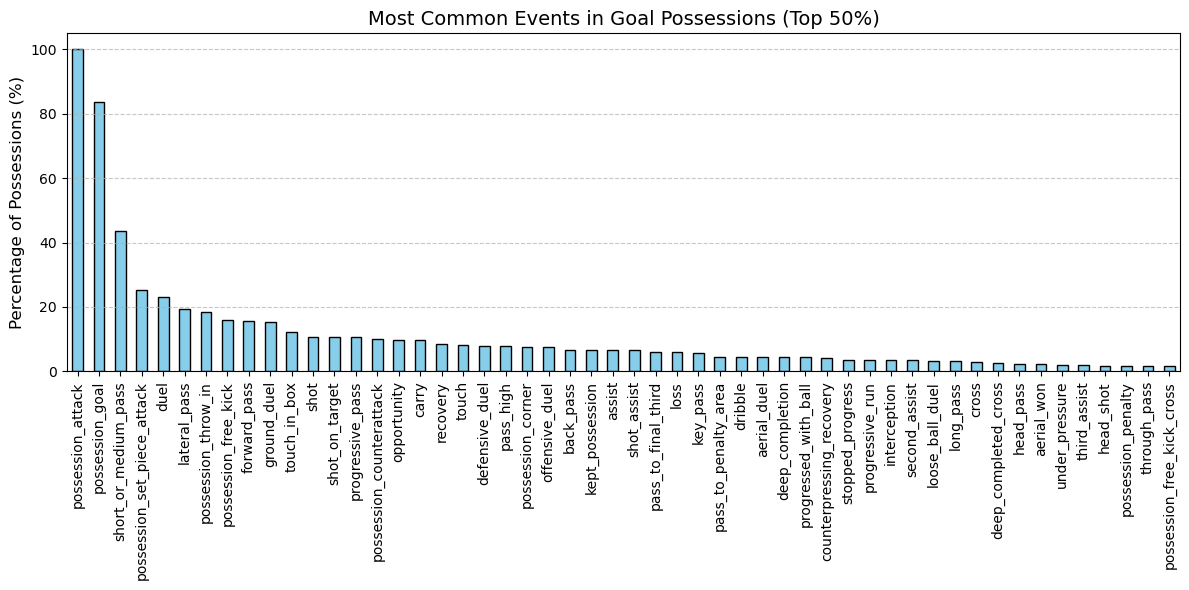

In [44]:
# Select only the event columns (exclude non-event columns and 'goal')
event_columns = [col for col in filtered_stories_df.columns if filtered_stories_df[col].dtype == 'bool' and col != 'goal']

# Count occurrences of each event in the filtered DataFrame
event_counts = filtered_stories_df[event_columns].sum()

# Calculate relative percentages
total_possessions = len(filtered_stories_df)
event_percentages = (event_counts / total_possessions * 100).sort_values(ascending=False)

# Split into two halves
mid_index = len(event_percentages) // 2
top_half = event_percentages[:mid_index]
bottom_half = event_percentages[mid_index:]

# Plot the top half
plt.figure(figsize=(12, 6))
top_half.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Most Common Events in Goal Possessions (Top 50%)', fontsize=14)
plt.ylabel('Percentage of Possessions (%)', fontsize=12)
plt.xticks(rotation=90)  # Rotate x-tick labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

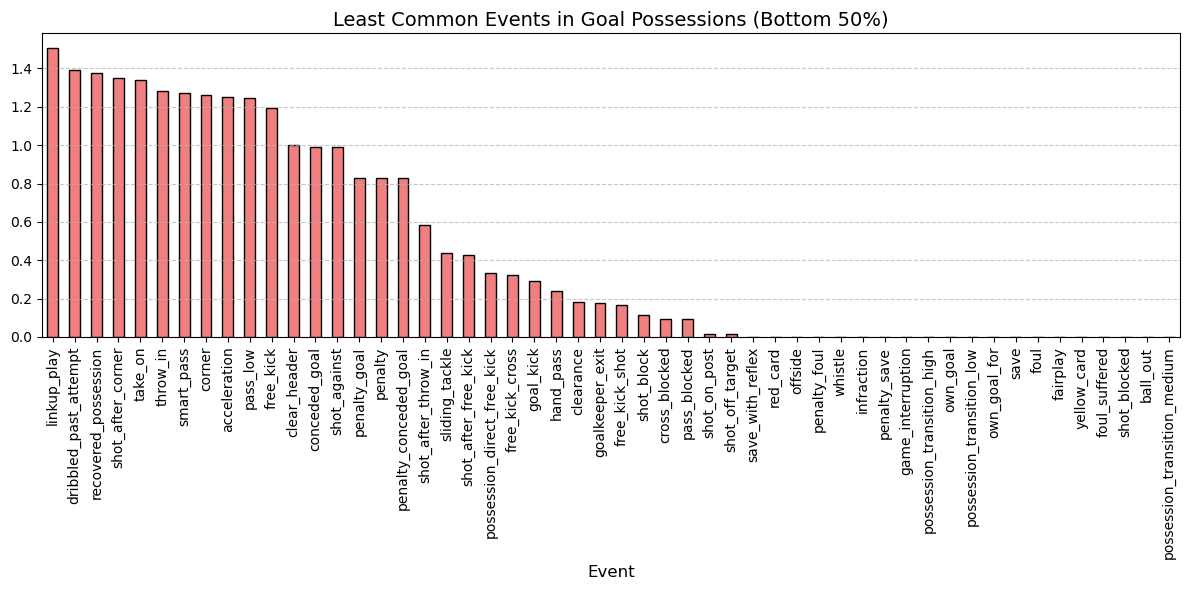

In [45]:
# Plot the bottom half
plt.figure(figsize=(12, 6))
bottom_half.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Least Common Events in Goal Possessions (Bottom 50%)', fontsize=14)
plt.xlabel('Event', fontsize=12)
plt.xticks(rotation=90)  # Rotate x-tick labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()